In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import t
import numpy as np

mat_path = "./data/Combo3_V1AL/GLM_GPT_cor.mat"

import scipy.io
corr_mat = scipy.io.loadmat(mat_path)

def calculate_p_value(r, n):
    t_statistic = r * np.sqrt((n - 2) / (1 - r**2))
    p_value = 2 * (1 - t.cdf(abs(t_statistic), df=n-2))
    return p_value

def add_p_values(correlation_data):
    for model_name, intervals in correlation_data.items():
        for interval, correlation in intervals.items():
            pearson_r = correlation['pearson_r']
            n = len(pearson_r)
            pearson_p = calculate_p_value(pearson_r, n)
            correlation['pearson_p'] = pearson_p

glm_corr_1 = pd.DataFrame({"ID": np.arange(len(corr_mat['GLM_pred_test_cor'])),
                           "pearson_r": corr_mat['GLM_pred_test_cor'][:, 0]})
glm_corr_2 = pd.DataFrame({"ID": np.arange(len(corr_mat['GLM_pred_test_cor'])),
                           "pearson_r": corr_mat['GLM_pred_test_cor'][:, 1]})
glm_corr_3 = pd.DataFrame({"ID": np.arange(len(corr_mat['GLM_pred_test_cor'])),
                           "pearson_r": corr_mat['GLM_pred_test_cor'][:, 2]})

nf_corr_1 = pd.DataFrame({"ID": np.arange(len(corr_mat['GPT_pred_test_cor'])),
                          "pearson_r": corr_mat['GPT_pred_test_cor'][:, 0]})
nf_corr_2 = pd.DataFrame({"ID": np.arange(len(corr_mat['GPT_pred_test_cor'])),
                          "pearson_r": corr_mat['GPT_pred_test_cor'][:, 1]})
nf_corr_3 = pd.DataFrame({"ID": np.arange(len(corr_mat['GPT_pred_test_cor'])),
                          "pearson_r": corr_mat['GPT_pred_test_cor'][:, 2]})

real_corr_1 = pd.DataFrame({"ID": np.arange(len(corr_mat['data_train_test_cor'])),
                            "pearson_r": corr_mat['data_train_test_cor'][:, 0]})
real_corr_2 = pd.DataFrame({"ID": np.arange(len(corr_mat['data_train_test_cor'])),
                            "pearson_r": corr_mat['data_train_test_cor'][:, 1]})
real_corr_3 = pd.DataFrame({"ID": np.arange(len(corr_mat['data_train_test_cor'])),
                            "pearson_r": corr_mat['data_train_test_cor'][:, 2]})

correlations_by_interval_dict = {
    1: {"GLM": glm_corr_1, "Neuroformer": nf_corr_1, "Real": real_corr_1},
    2: {"GLM": glm_corr_2, "Neuroformer": nf_corr_2, "Real": real_corr_2},
    3: {"GLM": glm_corr_3, "Neuroformer": nf_corr_3, "Real": real_corr_3},
}

add_p_values(correlations_by_interval_dict)

GLM
Neuroformer
Real
GLM
Neuroformer
Real
GLM
Neuroformer
Real


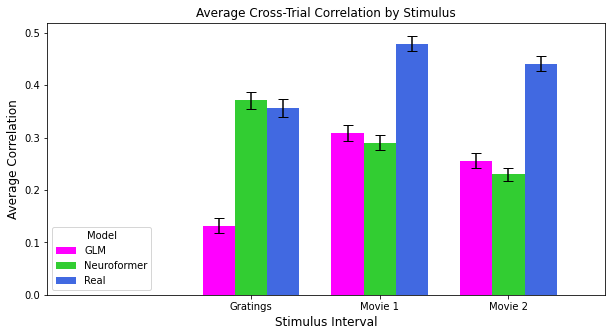

In [2]:
from scipy.stats import ttest_ind, t

# Extract average correlation, and standard deviations for each dataset within each interval
data = {
    'Interval': [],
    'Dataset': [],
    'Average Correlation': [],
}

colors = {
    "Real": 'royalblue',
    "Neuroformer": 'limegreen',  # Vibrant Green
    "GLM": 'magenta',  # Magenta (Fuchsia-like)'
}

glm_neuro_ttest = []
glm_neuro_pvalue = []
glm_neuro_conf_int = []
neuro_real_ttest = []
neuro_real_pvalue = []
neuro_real_conf_int = []
standard_errors = {'GLM': [], 'Neuroformer': [], 'Real': []}


for n_stim, (interval, correlation_data) in enumerate(correlations_by_interval_dict.items()):
    for model_name, dataset_corr in correlation_data.items():
        print(model_name)
        data['Interval'].append(str(interval))
        data['Dataset'].append(model_name)
        avg_corr = round(dataset_corr['pearson_r'].mean(), 3)
        avg_p = dataset_corr['pearson_p']
        data['Average Correlation'].append(avg_corr)
        # data['Average P-value'].append(avg_p)
        corr_values = dataset_corr['pearson_r']
        standard_error = corr_values.std() / np.sqrt(len(corr_values))
        standard_errors[model_name].append(standard_error)
        
        if model_name == 'Neuroformer':
            corr_neur = correlation_data['Neuroformer']['pearson_r']
            corr_glm = correlation_data['GLM']['pearson_r']
            t_stat, p_value = ttest_ind(corr_neur, corr_glm)
            if round(p_value, 3) == 0.0:
                p_value = 0.001
            glm_neuro_ttest.append(t_stat)
            glm_neuro_pvalue.append(p_value)

            # Calculate confidence interval
            confidence_level = 0.95
            degrees_freedom = len(corr_values) - 1
            conf_int = t.interval(confidence_level, degrees_freedom, avg_corr, standard_error)
            glm_neuro_conf_int.append(conf_int)
        
        if model_name == 'Real':
            corr_neur = correlation_data['Neuroformer']['pearson_r']
            corr_real = correlation_data['Real']['pearson_r']
            t_stat, p_value = ttest_ind(corr_real, corr_neur)
            if round(p_value, 3) == 0.0:
                p_value = 0.001
            neuro_real_ttest.append(t_stat)
            neuro_real_pvalue.append(p_value)

            # Calculate confidence interval
            confidence_level = 0.95
            degrees_freedom = len(corr_values) - 1
            conf_int = t.interval(confidence_level, degrees_freedom, avg_corr, standard_error)
            neuro_real_conf_int.append(conf_int)



df_bar = pd.DataFrame(data)
unique_intervals = df_bar['Interval'].unique()


plt.figure(figsize=(10, 5))

# Define the order of the datasets
order = ['GLM', 'Neuroformer', 'Real']

# Number of bars per group
num_bars = len(colors)
offset = 0.4
bar_width = 0.15
group_separation = 0.15  # Space between the groups of bars
bar_positions = np.arange(len(unique_intervals)) * (group_separation + num_bars * bar_width) + offset


# Iterate over the intervals and datasets, plotting each bar
for i, dataset in enumerate(order):
    y_values = df_bar[df_bar['Dataset'] == dataset]['Average Correlation']
    y_err_values = standard_errors[dataset] # Get the corresponding standard errors
    bars = plt.bar(bar_positions + i * bar_width + offset, y_values, width=bar_width, color=colors[dataset], yerr=y_err_values, capsize=5) # Add yerr parameter
    plt.xlim(0, max(bar_positions) + offset + bar_width * 4)

plt.xticks(ticks=bar_positions + offset + bar_width * (num_bars - 1) / 2, labels=['Gratings', 'Movie 1', 'Movie 2'])
plt.title("Average Cross-Trial Correlation by Stimulus")
plt.ylabel('Average Correlation', fontsize=12)
plt.xlabel('Stimulus Interval', fontsize=12)
plt.legend(title='Model', loc='lower left', labels=order)

# Modify the text positioning to place the text between groups of three bars
for i, interval in enumerate(unique_intervals):
    y_pos = df_bar[df_bar['Interval'] == interval]['Average Correlation'].max() + 0.005
    # plt.text(bar_positions[i] + bar_width * (num_bars / 2), y_pos, f't-test GLM-NF p < {glm_neuro_ttest[i]:.3f}', ha='center', bbox=dict(facecolor='white', edgecolor='none', pad=0))
    # plt.text(bar_positions[i] + bar_width * (num_bars / 2), y_pos + 0.005, f't-test Real-NF p < {neuro_real_ttest[i]:.3f}', ha='center', bbox=dict(facecolor='white', edgecolor='none', pad=0))

for dataset_index, dataset in enumerate(order):
    y_values = df_bar[df_bar['Dataset'] == dataset]['Average Correlation']
    y_err_values = standard_errors[dataset]  # Get the corresponding standard errors
    for bar_index, value in enumerate(y_values):
        x_position = bar_positions[bar_index] + dataset_index * bar_width + offset
        y_position = value + y_err_values[bar_index] + 0.002  # Adjust this value if needed to position the text above the error bar
        # plt.text(x_position, y_position, round(value, 2), ha='center', va='bottom', fontsize=9)

save_path = "./_rebuttal/V1_AL/corrs"
if not os.path.exists(save_path):
    os.makedirs(save_path)
plt.savefig(os.path.join(save_path, "corrs_bar.pdf"), dpi=300, bbox_inches='tight')

In [3]:
df_bar[df_bar['Dataset'] == 'Real'].mean()

/tmp/ipykernel_2445900/2983069892.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_bar[df_bar['Dataset'] == 'Real'].mean()


Interval               41.000000
Average Correlation     0.425333
dtype: float64

In [4]:
np.mean(standard_errors['Real'])

0.015308380134061913